# Técnicas que serão utilizadas

* Divisão de dados em treino e teste
* Feature selection (Heatmat)
* Label Encoder (Transforma valores categoricos em númericos)
* Random Forest (Conjunto de Árvores de decisão)
* Curva de aprendizado (Ánalise de Under/Overfiting)
* Ánalise de overfiting ou underfiting
* Otimização de Hiperparâmetros
* Cross Validation
* Verificação de importância de cada feature
* Visualização de predições

# Entendendo os dados

In [1]:
# Importando as bibliotecas que serão utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import learning_curve

In [2]:
# Carregado base de dados
df = pd.read_csv('ds_salaries.csv')

In [3]:
# Entendendo a base de dados
df.shape

(3755, 11)

In [4]:
# Visualizando os dados
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


Nossa objetivo nesse dataset é prever o valor da coluna "salary_in_usd" a partir dos outros dados, para isso vamos excluir a coluna "salary" que torna a solução trivial que seria so uma conversão de moeda.

In [5]:
df = df.drop(columns=['salary'])

In [6]:
# Verificando se existem valores nulos
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [7]:
# Verificando os tipos das colunas
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [8]:
# Verificando o número de ocorrências das colunas não númericas
df.select_dtypes(exclude='number').nunique()

experience_level       4
employment_type        4
job_title             93
salary_currency       20
employee_residence    78
company_location      72
company_size           3
dtype: int64

Ao observar esse número de ocorrência das colunas categoricas é possível observar que a coluna "job_title" pode ser um problema.

In [9]:
df['job_title'].unique()

array(['Principal Data Scientist', 'ML Engineer', 'Data Scientist',
       'Applied Scientist', 'Data Analyst', 'Data Modeler',
       'Research Engineer', 'Analytics Engineer',
       'Business Intelligence Engineer', 'Machine Learning Engineer',
       'Data Strategist', 'Data Engineer', 'Computer Vision Engineer',
       'Data Quality Analyst', 'Compliance Data Analyst',
       'Data Architect', 'Applied Machine Learning Engineer',
       'AI Developer', 'Research Scientist', 'Data Analytics Manager',
       'Business Data Analyst', 'Applied Data Scientist',
       'Staff Data Analyst', 'ETL Engineer', 'Data DevOps Engineer',
       'Head of Data', 'Data Science Manager', 'Data Manager',
       'Machine Learning Researcher', 'Big Data Engineer',
       'Data Specialist', 'Lead Data Analyst', 'BI Data Engineer',
       'Director of Data Science', 'Machine Learning Scientist',
       'MLOps Engineer', 'AI Scientist', 'Autonomous Vehicle Technician',
       'Applied Machine Learning Sc

É possível ver algumas redundâncias incoerrentes com a existência de uma coluna que diz o nível de senioriade, então organizamos melhor esses dados.

In [10]:
df['job_title'].value_counts(normalize=True)[:10]

Data Engineer                0.276964
Data Scientist               0.223702
Data Analyst                 0.162983
Machine Learning Engineer    0.076964
Analytics Engineer           0.027430
Data Architect               0.026897
Research Scientist           0.021838
Data Science Manager         0.015446
Applied Scientist            0.015446
Research Engineer            0.009854
Name: job_title, dtype: float64

In [11]:
data_eng = ['Data Architect']
data_sci = ['Applied Scientist','Research Engineer','Research Scientist','Data Science Manager']
data_ana = ['Analytics Engineer']

df['job_title'] = df['job_title'].replace(data_sci, 'Data Scientist')
df['job_title'] = df['job_title'].replace(data_eng, 'Data Engineer')
df['job_title'] = df['job_title'].replace(data_ana, 'Data Analyst')

jobs = ['Data Engineer','Data Scientist','Data Analyst','Machine Learning Engineer']

df.drop(df[~df['job_title'].isin(jobs)].index, inplace = True)

In [12]:
df['job_title'].value_counts(normalize=True)

Data Engineer                0.354348
Data Scientist               0.333851
Data Analyst                 0.222050
Machine Learning Engineer    0.089752
Name: job_title, dtype: float64

Selecionamos os 4 principais para serem utilizados, foram realocados os outros com maiores ocorrências e removidos os restantes.

In [13]:
df.describe()

,work_year,salary_in_usd,remote_ratio
count,3220.000000,3220.000000,3220.000000
mean,2022.415839,140210.826398,44.937888
std,0.651948,60278.903317,48.868806
min,2020.000000,5679.000000,0.000000
25%,2022.000000,100000.000000,0.000000
50%,2022.000000,136000.000000,0.000000
75%,2023.000000,178637.500000,100.000000
max,2023.000000,450000.000000,100.000000


# Organizando os dados

Separando algumas possibilidades de features e o target.

In [14]:
# Divisão de dados em features e target
# Selecionando todas as colunas como features

X = df.drop(columns='salary_in_usd', axis=1)
y = df['salary_in_usd']

In [15]:
# Transformação de dados categoricos para númericos utilizando o Label Encoder

encoder = LabelEncoder()
categorical_features = list(X.columns)
for each in categorical_features:
    X[each] = encoder.fit_transform(X[each])

In [16]:
# Divisão dOS dados 80%  para treino e 20% para teste

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 2)

# Treinando o modelo

Algoritmos utilizados

* DecisionTreeRegressor
* RandomForestRegressor

DecisionTreeRegressor - mais rápido que o KNN, melhor utilizado em conjuntos de dados maiores e mais complexos, pode ser mais impreciso

RandomForestRegressor - algoritmo utilizado como método de ensemble para deixar o modelo mais robusto e diminuir a variancia, tem como base a média de diversas árvores menores.

In [17]:
# Utilizaremos os Algoritmos citados acima

model_rf = RandomForestRegressor(random_state=2)
model_dt = DecisionTreeRegressor(random_state=2)

In [18]:
# Treinando os modelos com os dados de treino

model_rf.fit(X_train,y_train)
model_dt.fit(X_train,y_train)

DecisionTreeRegressor(random_state=2)

In [19]:
# Prevendo os resultados dos dados de teste

y_pred_rf = model_rf.predict(X_test)
y_pred_dt = model_dt.predict(X_test)

In [20]:
# Avaliando o desempenho dos algoritmos verificando a sua influência no resultado e o seu erro médio 

print('Métricas de desempenho do algoritmo RandomForestRegressor')
print(r2_score(y_test, y_pred_rf))
print(mean_absolute_error(y_test, y_pred_rf))
print('-'*60)
print('Métricas de desempenho do algoritmo DecisionTreeRegressor')
print(r2_score(y_test, y_pred_dt))
print(mean_absolute_error(y_test, y_pred_dt))

Métricas de desempenho do algoritmo RandomForestRegressor
0.3890497862133584
36622.87957123584
------------------------------------------------------------
Métricas de desempenho do algoritmo DecisionTreeRegressor
0.3605803592526391
37714.6994246695


# Otimizando Hiperparâmetros

In [21]:
# Variáveis que serão testadas para avaliar qual melhor parâmetro a ser utilizado
n_estimators = [5,20,50,70,100] # numero de árvores na floresta
max_features = ['auto', 'sqrt'] # número de features em consideração em cada divisão
max_depth = [int(x) for x in np.linspace(10, 50, num = 25)] # profundidade das árvores
min_samples_split = [2, 6, 10] # número mínimo de amostras necessárias para dividir um nó interno
min_samples_leaf = [1, 3, 4] # número mínimo de amostras que deve existir em cada folha

In [22]:
random_grid_tree = {
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

In [23]:
# modelo que será comparado para encontrar os melhores parâmetros
dt  = DecisionTreeRegressor(max_depth=120, max_features='auto', min_samples_leaf=3, min_samples_split=10)
dt_random = RandomizedSearchCV(estimator = dt,param_distributions = random_grid_tree, n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

dt_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeRegressor(max_depth=120,
                                                   max_features='auto',
                                                   min_samples_leaf=3,
                                                   min_samples_split=10),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 11, 13, 15, 16, 18,
                                                      20, 21, 23, 25, 26, 28,
                                                      30, 31, 33, 35, 36, 38,
                                                      40, 41, 43, 45, 46, 48,
                                                      50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10]},
                   random_state=35, verbose=2)

In [24]:
print ('Random grid: ', random_grid_tree, '\n')
print ('Best Parameters: ', dt_random.best_params_, ' \n')

Random grid:  {'max_features': ['auto', 'sqrt'], 'max_depth': [10, 11, 13, 15, 16, 18, 20, 21, 23, 25, 26, 28, 30, 31, 33, 35, 36, 38, 40, 41, 43, 45, 46, 48, 50], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4]} 

Best Parameters:  {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 38}  



In [25]:
# Utilizando os parâmetros otimizados para treinar o modelo
model_dt_otim = DecisionTreeRegressor(max_depth=38, max_features='auto', min_samples_leaf=4, min_samples_split=10)
model_dt_otim.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=38, max_features='auto', min_samples_leaf=4,
                      min_samples_split=10)

In [26]:
y_train_pred_dt_otim = model_dt_otim.predict(( X_train))
y_test_pred_dt_otim = model_dt_otim.predict(( X_test ))

In [27]:
# Visualizando os resultados do modelo com parâmetros otimizados
print('Resultados de Treino')
print(r2_score(y_train, y_train_pred_dt_otim))
print(mean_absolute_error(y_train, y_train_pred_dt_otim))
print('Resultados de Teste')
print(r2_score(y_test, y_test_pred_dt_otim))
print(mean_absolute_error(y_test, y_test_pred_dt_otim))

Resultados de Treino
0.44964818277161844
33322.02671650307
Resultados de Teste
0.38500049794632485
36969.96588543402


In [28]:
random_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
}

In [29]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

rf_random.fit(X_train, y_train)

print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random grid:  {'n_estimators': [5, 20, 50, 70, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 11, 13, 15, 16, 18, 20, 21, 23, 25, 26, 28, 30, 31, 33, 35, 36, 38, 40, 41, 43, 45, 46, 48, 50], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4]} 

Best Parameters:  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 16}  



In [30]:
model_rf_otim = RandomForestRegressor(n_estimators=70, min_samples_split=10, min_samples_leaf=3, max_features='sqrt', max_depth=20)
model_rf_otim.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=10, n_estimators=70)

In [31]:
y_train_pred_rf_otim = model_rf_otim.predict(( X_train))
y_test_pred_rf_otim = model_rf_otim.predict(( X_test ))

In [32]:
print('Resultados de Treino')
print(r2_score(y_train, y_train_pred_rf_otim))
print(mean_absolute_error(y_train, y_train_pred_rf_otim))
print('Resultados de Teste')
print(r2_score(y_test, y_test_pred_rf_otim))
print(mean_absolute_error(y_test, y_test_pred_rf_otim))


Resultados de Treino
0.4398775457446513
33850.307276210515
Resultados de Teste
0.3876312679802659
36641.510659051484


Optamos por seguir com o random Forest

# Cross Validation

In [33]:
# Tabela com os melhores scores para cada variação 
df_search = pd.DataFrame(rf_random.cv_results_)
df_search.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.307827,0.019667,0.023592,0.003773,100,10,3,sqrt,16,"{'n_estimators': 100, 'min_samples_split': 10,...",0.336944,0.421698,0.448129,0.369614,0.414421,0.398161,0.039693,1
26,0.212509,0.015067,0.014798,0.000759,70,2,3,sqrt,43,"{'n_estimators': 70, 'min_samples_split': 2, '...",0.336075,0.428928,0.444031,0.370353,0.410769,0.398031,0.039592,2
30,0.131772,0.001817,0.012581,0.001945,50,10,3,sqrt,41,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.333769,0.421823,0.446715,0.369585,0.414391,0.397256,0.040348,3
48,0.328742,0.042431,0.030223,0.007342,100,10,3,sqrt,10,"{'n_estimators': 100, 'min_samples_split': 10,...",0.337885,0.417167,0.447270,0.367809,0.416139,0.397254,0.039106,4
42,0.180574,0.017121,0.012195,0.001603,50,2,3,sqrt,45,"{'n_estimators': 50, 'min_samples_split': 2, '...",0.339277,0.412413,0.444830,0.376247,0.412489,0.397051,0.036133,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,0.457181,0.021030,0.028111,0.004568,100,2,1,auto,36,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.265875,0.405311,0.434482,0.356732,0.395712,0.371622,0.058431,96
50,0.023693,0.003276,0.004997,0.002605,5,6,1,auto,10,"{'n_estimators': 5, 'min_samples_split': 6, 'm...",0.270514,0.411583,0.436422,0.351672,0.384403,0.370919,0.057581,97
20,0.420080,0.022661,0.022982,0.001275,100,2,1,auto,35,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.250393,0.413366,0.437809,0.357082,0.393575,0.370445,0.065584,98
11,0.021552,0.001736,0.004593,0.001019,5,2,1,sqrt,28,"{'n_estimators': 5, 'min_samples_split': 2, 'm...",0.277749,0.383222,0.421635,0.350427,0.405052,0.367617,0.050862,99


In [34]:
# Verificação da influência de cada feature 

feat_imp = model_rf_otim.feature_importances_
feat_name = X.columns

for i in range(len(X.columns)):
    print(f'{feat_name[i]}: {str(round(feat_imp[i]*100,2))}%')


work_year: 4.13%
experience_level: 16.4%
employment_type: 0.0%
job_title: 16.12%
salary_currency: 23.53%
employee_residence: 21.5%
remote_ratio: 2.28%
company_location: 13.72%
company_size: 2.31%


# Visualizando os resultados

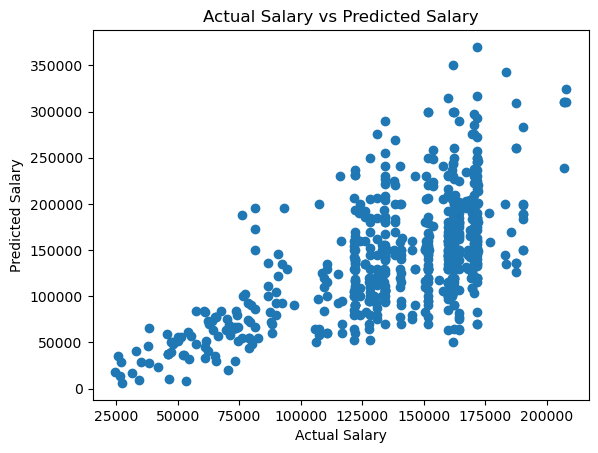

In [35]:
# Visualização de dados de teste vs dados previstos
plt.scatter(y_test_pred_rf_otim, y_test)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual Salary vs Predicted Salary")
plt.show()

In [36]:
# Correlação dos dados
df_selecao = pd.DataFrame(X_train, columns=X_train.columns)
df_selecao['salary_in_usd'] = y_train
corr = df_selecao.corr(method='pearson')

<AxesSubplot:>

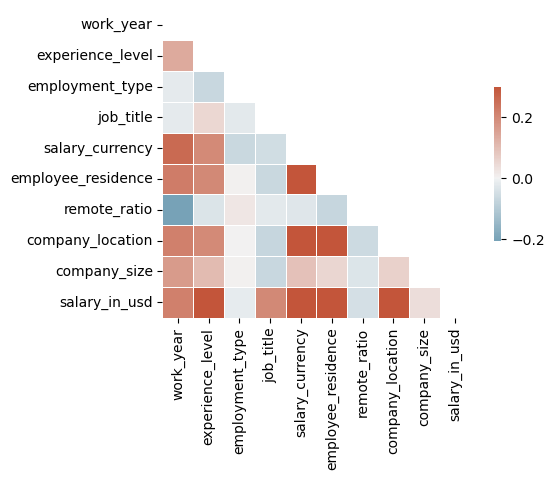

In [37]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Heatmat da Correlações
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(6, 4))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

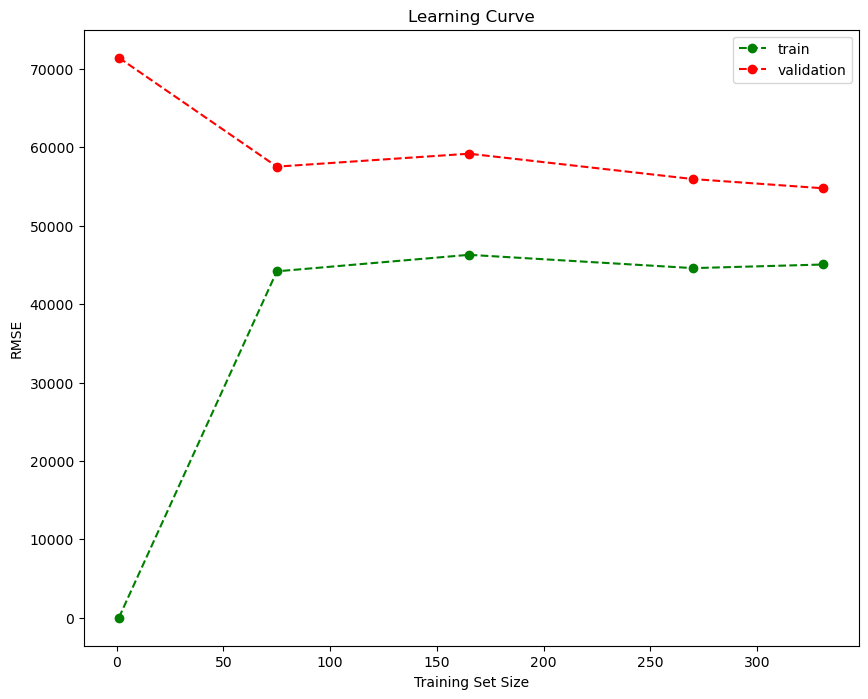

In [38]:
# Curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_rf,
    X=X,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes = [1, 75, 165, 270, 331]
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, 'o--', label="train",color='g')
plt.plot(train_sizes, test_mean, 'o--', label="validation",color='r')

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()


É possível ver um nível de erro alto e uma estabilização, é categorizado como um underfiting e avaliamos como necessário mais dados para conseguir uma performace melhor.